In [62]:
!pip3 install ucimlrepo

# Imports

In [63]:
import torch
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import warnings
import random
import os
import gc

from ucimlrepo import fetch_ucirepo
from sklearn.datasets import make_classification
from sklearn.decomposition import (
    PCA, IncrementalPCA, SparsePCA, MiniBatchSparsePCA, KernelPCA,
    TruncatedSVD, DictionaryLearning, MiniBatchDictionaryLearning,
    FactorAnalysis, FastICA, NMF, LatentDirichletAllocation
)
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis
)
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier as RFC, GradientBoostingClassifier as GBC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

from time import time
from itertools import combinations
from tqdm.notebook import tqdm
from torch import nn, optim

RANDOM_STATE = 10
N_JOBS = -1
ALL_FEATURES_STR = "All_features"
# Set random seed for numpy
np.random.seed(RANDOM_STATE)
# Set random seed for random module
random.seed(RANDOM_STATE)

## Real data
### Breast Cancer Wisconsin (Diagnostic) Dataset
Benign/malign binary classification task

In [64]:
cancer_df = pd.DataFrame(fetch_ucirepo(id=17).data.features)
cancer_df['class'] = fetch_ucirepo(id=17).data.targets
cancer_df

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,M
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,M
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,M
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,M


#### Description statistics

In [65]:
cancer_df.describe()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [66]:
cancer_df.describe(include='object')

,class
count,569
unique,2
top,B
freq,357


#### Missing values check

In [67]:
missing_values = cancer_df.isnull().any()
print(f"Is there missing values in dry_bean_df:\n{missing_values}")

Is there missing values in dry_bean_df:
radius1               False
texture1              False
perimeter1            False
area1                 False
smoothness1           False
compactness1          False
concavity1            False
concave_points1       False
symmetry1             False
fractal_dimension1    False
radius2               False
texture2              False
perimeter2            False
area2                 False
smoothness2           False
compactness2          False
concavity2            False
concave_points2       False
symmetry2             False
fractal_dimension2    False
radius3               False
texture3              False
perimeter3            False
area3                 False
smoothness3           False
compactness3          False
concavity3            False
concave_points3       False
symmetry3             False
fractal_dimension3    False
class                 False
dtype: bool


#### Target variable distribution

In [68]:
cancer_df['class'].value_counts()

class
B    357
M    212
Name: count, dtype: int64

In [69]:
label_encoder = LabelEncoder()
cancer_df['class'] = label_encoder.fit_transform(cancer_df['class']) # encoding the target variable
features = cancer_df.columns.drop('class')
X, y = cancer_df[features].values, cancer_df['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y) # stratified train/test split

sscaler = StandardScaler()
sscaler.fit(X_train)
X_train_norm = sscaler.transform(X_train)
X_test_norm = sscaler.transform(X_test)

mmscaler = MinMaxScaler(clip=True)
mmscaler.fit(X_train)
X_train_mms = mmscaler.transform(X_train)
X_test_mms = mmscaler.transform(X_test)

### Sklearn dimensionality reduction
#### Neccessary methods

In [70]:
def dimensionality_reduction(reducer, X_train, X_test, fit_caller=lambda reducer, X: reducer.fit(X)):
    tic = time()
    fit_caller(reducer, X_train)
    toc = time()
    X_train_transformed = reducer.transform(X_train)
    X_test_transformed = reducer.transform(X_test)
    return reducer, X_train_transformed, X_test_transformed, toc - tic


def perform_dimensionality_reduction(n_components, X_train_norm, X_train_mms, X_test_norm, X_test_mms, y_train):
    """
    Perform dimensionality reduction on the given datasets using various reducers.

    Args:
        n_components (int): The number of components to keep.
        X_train_norm (array-like): The normalized training dataset.
        X_train_mms (array-like): The min-max scaled training dataset.
        X_test_norm (array-like): The normalized testing dataset.
        X_test_mms (array-like): The min-max scaled testing dataset.
        y_train (array-like): The target variable for training.

    Returns:
        list: A list of dictionaries containing the transformed datasets and delta values for each reducer.

    """
    reducers = [
        (PCA(n_components=0.85, svd_solver='full', random_state=RANDOM_STATE), True, False),
        (IncrementalPCA(n_components=n_components), True, False),
        (PCA(n_components=n_components, svd_solver='randomized', random_state=RANDOM_STATE), True, False),
        (SparsePCA(n_components=n_components, n_jobs=N_JOBS, random_state=RANDOM_STATE), True, False),
        (MiniBatchSparsePCA(n_components=n_components, n_jobs=N_JOBS, random_state=RANDOM_STATE), True, False),
        (KernelPCA(n_components=n_components, n_jobs=N_JOBS, kernel='linear', random_state=RANDOM_STATE), True, False),
        (KernelPCA(n_components=n_components, n_jobs=N_JOBS, kernel='poly', random_state=RANDOM_STATE), True, False),
        (KernelPCA(n_components=n_components, n_jobs=N_JOBS, kernel='rbf', random_state=RANDOM_STATE), True, False),
        (KernelPCA(n_components=n_components, n_jobs=N_JOBS, kernel='sigmoid', random_state=RANDOM_STATE), True, False),
        (KernelPCA(n_components=n_components, n_jobs=N_JOBS, kernel='cosine', random_state=RANDOM_STATE), True, False),
        (TruncatedSVD(n_components=n_components, random_state=RANDOM_STATE), True, False),
        (DictionaryLearning(n_components=n_components, n_jobs=N_JOBS, random_state=RANDOM_STATE), True, False),
        (MiniBatchDictionaryLearning(n_components=n_components, n_jobs=N_JOBS, random_state=RANDOM_STATE), True, False),
        (FactorAnalysis(n_components=n_components, random_state=RANDOM_STATE), True, False),
        (FastICA(n_components=n_components, max_iter=500, random_state=RANDOM_STATE), True, False),
        (NMF(n_components=n_components, max_iter=500, random_state=RANDOM_STATE), False, False),
        (LatentDirichletAllocation(n_components=n_components, random_state=RANDOM_STATE), False, False),
        (LinearDiscriminantAnalysis(), True, True)
    ]
    
    results = []
    for reducer_info in tqdm(reducers):
        reducer, use_norm, use_fit_caller = reducer_info
        X_train = X_train_norm if use_norm else X_train_mms
        X_test = X_test_norm if use_norm else X_test_mms
        if use_fit_caller:
            reducer, X_train_transformed, X_test_transformed, delta =\
                dimensionality_reduction(
                    reducer, X_train, X_test,
                    lambda reducer, X: reducer.fit(X, y_train)
                )
        else:
            reducer, X_train_transformed, X_test_transformed, delta =\
                dimensionality_reduction(
                    reducer, X_train, X_test
                )

        key = reducer.__class__.__name__
        if key == 'KernelPCA': key += f"_{reducer.kernel}"
        elif key == 'PCA': key += f"_{reducer.svd_solver}"

        results.append({key: (X_train_transformed, X_test_transformed, delta)})
    return results


def evaluate_and_plot(results, y_train, y_test):
    """
    Evaluate and plot the performance of dimensionality reduction methods.

    Args:
        results (list): A list of dictionaries containing the results of dimensionality reduction methods.
                        Each dictionary should have the following structure:
                        {
                            'method_name': (X_train_transformed, X_test_transformed, delta_time)
                        }
                        where 'method_name' is a string representing the name of the dimensionality reduction method,
                        X_train_transformed is the transformed training data,
                        X_test_transformed is the transformed testing data,
                        and delta_time is the time taken for the transformation.
        y_train (array-like): The target values of the training data.
        y_test (array-like): The target values of the testing data.
    """
    lr_scores = np.empty(len(results), dtype=object)
    gbc_scores = np.empty(len(results), dtype=object)
    delta_times = np.empty(len(results), dtype=object)
    dr_methods = np.empty(len(results), dtype=object)

    for idx, result in enumerate(results):
        key, value = list(result.items())[0]

        dr_methods[idx] = key + f" k={value[0].shape[1]}"
        X_train_transformed, X_test_transformed, delta = value
        delta_times[idx] = delta

        lr = LogisticRegression()
        lr.fit(X_train_transformed, y_train)
        lr_scores[idx] = accuracy_score(y_test, lr.predict(X_test_transformed))

        gbc = GBC(random_state=RANDOM_STATE)
        gbc.fit(X_train_transformed, y_train)
        gbc_scores[idx] = accuracy_score(y_test, gbc.predict(X_test_transformed))

    x = range(len(dr_methods))
    width = 0.2
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.bar([i - width / 2 for i in x], lr_scores, width=width, label='Logistic Regression')
    ax1.bar([i + width / 2 for i in x], gbc_scores, width=width, label='Gradient Boosting Classifier')
    ax1.set_xlabel('Dimensionality Reduction Method')
    ax1.set_ylabel('Accuracy', color='b')
    ax1.tick_params('y', colors='b')
    ax1.legend(loc='center right', bbox_to_anchor=(1, 0.4))

    ax2 = ax1.twinx()
    ax2.plot(x, delta_times, label='Delta Time', color='r', marker='.')
    ax2.set_ylabel('Delta Time', color='r')
    ax2.tick_params('y', colors='r')
    ax2.legend(loc='center right', bbox_to_anchor=(1, 0.55))

    # Set the x-axis ticks and labels
    ax1.set_xticks(np.arange(len(dr_methods)))
    ax1.set_xticklabels(dr_methods, rotation=90)

    plt.title('Performance of Dimensionality Reduction Methods')
    plt.tight_layout()
    plt.show()
    
    lr_best_score = max(lr_scores)
    lr_worst_score = min(lr_scores)
    gbc_best_score = max(gbc_scores)
    gbc_worst_score = min(gbc_scores)

    lr_best_methods = [dr_methods[i] for i, score in enumerate(lr_scores) if score == lr_best_score]
    lr_worst_methods = [dr_methods[i] for i, score in enumerate(lr_scores) if score == lr_worst_score]
    gbc_best_methods = [dr_methods[i] for i, score in enumerate(gbc_scores) if score == gbc_best_score]
    gbc_worst_methods = [dr_methods[i] for i, score in enumerate(gbc_scores) if score == gbc_worst_score]

    return (lr_best_methods, lr_best_score, lr_worst_methods, lr_worst_score,\
           gbc_best_methods, gbc_best_score, gbc_worst_methods, gbc_worst_score)

def print_best_worst(method_score_tuple):
    lr_best, lr_best_score, lr_worst, lr_worst_score, gbc_best, gbc_best_score, gbc_worst, gbc_worst_score = method_score_tuple
    print(f"Best performing methods for Logistic Regression: {', '.join(lr_best)} with accuracy: {lr_best_score}")
    print(f"Worst performing methods for Logistic Regression: {', '.join(lr_worst)} with accuracy: {lr_worst_score}")
    print(f"Best performing methods for Gradient Boosting Classifier: {', '.join(gbc_best)} with accuracy: {gbc_best_score}")
    print(f"Worst performing methods for Gradient Boosting Classifier: {', '.join(gbc_worst)} with accuracy: {gbc_worst_score}")

### Obtaining results for each DRA

  0%|          | 0/18 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_dict_learning.py:2290: FutureWarning: The default value of batch_size will change from 3 to 256 in 1.3.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


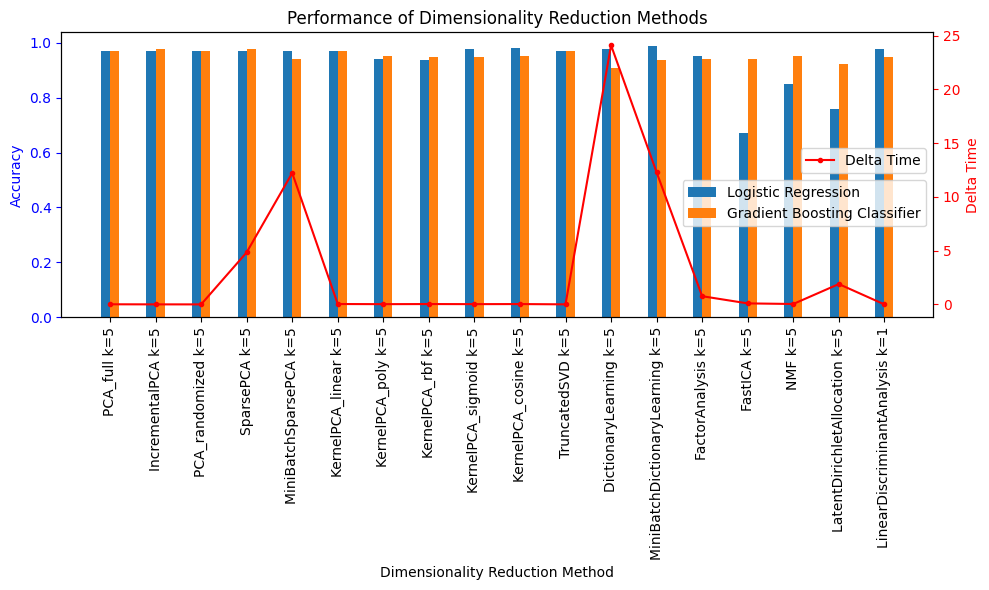

In [71]:
results = perform_dimensionality_reduction(5, X_train_norm, X_train_mms, X_test_norm, X_test_mms, y_train)
method_score_tuple = evaluate_and_plot(results, y_train, y_test)

In [72]:
print_best_worst(method_score_tuple)

Best performing methods for Logistic Regression: MiniBatchDictionaryLearning k=5 with accuracy: 0.9883040935672515
Worst performing methods for Logistic Regression: FastICA k=5 with accuracy: 0.672514619883041
Best performing methods for Gradient Boosting Classifier: IncrementalPCA k=5, SparsePCA k=5 with accuracy: 0.9766081871345029
Worst performing methods for Gradient Boosting Classifier: DictionaryLearning k=5 with accuracy: 0.9064327485380117


<font size="5">**Conclusions:**</font> As we can see, the accuracy of the GradientBoostingClassifier (GBC) is less dependent on the reduction algorithm choice, than of the LogisticsRegression (LR), which is expected, since GBC is more robust. However, with the right dimensionality reduction algorithm (DRA), in this case it's MiniBatchDictionaryLearning, we get better accuracy for LR then GBC. It's worth noting that MiniBatchDictionaryLearning provides better results then DictionaryLearning in terms of accuracy and fitting time, which is by the way the worst among all the DRA. We can see that choosing kernel in the KernelPCA is an important part, since it directly affects the accuracy.

## Encoder

In [7]:
# Make device agnostic code
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [8]:
# Seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(RANDOM_STATE)
# Set python seed
random.seed(RANDOM_STATE)
# Set numpy seed
np.random.seed(RANDOM_STATE)
# Force cuDNN to deterministically select an algorithm
# *possibly at the cost of reduced performance
torch.backends.cudnn.benchmark = False
# Configure PyTorch to use deterministic algorithms
# torch.use_deterministic_algorithms(True) (involves env. variables, so not used)

torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)

In [14]:
class Autoencoder(nn.Module):
    def __init__(self, in_shape, enc_shape=5, linear=True):
        super(Autoencoder, self).__init__()
        self.linear = linear

        if not linear:
            self.encoder = nn.Sequential(
                nn.Linear(in_shape, in_shape // 2),
                nn.ReLU(True),
                nn.Dropout(0.2),
                nn.Linear(in_shape // 2, enc_shape),
                nn.ReLU(True)
            )
            self.decoder = nn.Sequential(
                nn.BatchNorm1d(enc_shape),
                nn.Linear(enc_shape, in_shape // 2),
                nn.ReLU(True),
                nn.Dropout(0.2),
                nn.Linear(in_shape // 2, in_shape)
            )

        else:
            self.encoder = nn.Sequential(
                nn.Linear(in_shape, in_shape // 2),
                nn.Dropout(0.2),
                nn.Linear(in_shape // 2, enc_shape),
            )
            self.decoder = nn.Sequential(
                nn.BatchNorm1d(enc_shape),
                nn.Linear(enc_shape, in_shape // 2),
                nn.Dropout(0.2),
                nn.Linear(in_shape // 2, in_shape)
            )

    def load_checkpoint(self, filepath):
        checkpoint = torch.load(filepath)
        self.load_state_dict(checkpoint['model_state_dict'])
        print(f"Epoch:{checkpoint['epoch']} checkpoint with loss:{checkpoint['loss']} loaded.")

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

def train(model, criterion, optimizer, n_epochs, x):
    model.train()
    best_loss = float('inf')
    for epoch in tqdm(range(1, n_epochs + 1)):
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, f"best_{'linear' if model.linear else 'non_linear'}_model.pth")

        if epoch % int(0.1*n_epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')

            
def encode(model, x, criterion):
    with torch.no_grad():
        encoded = model.encoder(x)
        decoded = model.decoder(encoded)
        mse = criterion(decoded, x).item()
        enc = encoded.cpu().detach().numpy()

    del encoded, decoded
    gc.collect()
    torch.cuda.empty_cache()
    return enc, mse

In [29]:
encoder_results = []
criterion = nn.MSELoss()

In [30]:
def encode_with_autoencoder(
        X_train_norm, X_test_norm,
        encoder_results,
        criterion,
        n_components=5,
        linear=True,
        epochs=6500
    ):
    autoencoder = Autoencoder(
        in_shape=X_train_norm.shape[1], enc_shape=n_components, linear=linear
    ).double().to(DEVICE)
    optimizer = optim.Adam(autoencoder.parameters())
    x = torch.from_numpy(X_train_norm).to(DEVICE)
    tic = time()
    train(autoencoder, criterion, optimizer, epochs, x)
    toc = time()
    delta = toc - tic
    path = "/kaggle/working/best_linear_model.pth" if linear else "/kaggle/working/best_non_linear_model.pth"
    autoencoder.load_checkpoint(path)
    X_train_encoded, _ = encode(autoencoder, x, criterion)
    X_test_encoded, _ = encode(autoencoder, torch.from_numpy(X_test_norm).to(DEVICE), criterion)
    method_name = 'Linear_Autoencoder' if linear else 'Non_Linear_Autoencoder'
    encoder_results.append({method_name: (X_train_encoded, X_test_encoded, delta)})

In [41]:
encode_with_autoencoder(
    X_train_norm, X_test_norm,
    encoder_results, criterion, n_components=5, linear=True, epochs=11000)

  0%|          | 0/11000 [00:00<?, ?it/s]

epoch 1100 	 Loss: 0.2592
epoch 2200 	 Loss: 0.2508
epoch 3300 	 Loss: 0.2502
epoch 4400 	 Loss: 0.2505
epoch 5500 	 Loss: 0.2558
epoch 6600 	 Loss: 0.2539
epoch 7700 	 Loss: 0.2536
epoch 8800 	 Loss: 0.2559
epoch 9900 	 Loss: 0.2567
epoch 11000 	 Loss: 0.264
Epoch:2226 checkpoint with loss:0.2311584991914531 loaded.


In [38]:
encode_with_autoencoder(
    X_train_norm, X_test_norm,
    encoder_results, criterion, n_components=5, linear=False, epochs=11000)

  0%|          | 0/11000 [00:00<?, ?it/s]

epoch 1100 	 Loss: 0.3234
epoch 2200 	 Loss: 0.3255
epoch 3300 	 Loss: 0.3059
epoch 4400 	 Loss: 0.3102
epoch 5500 	 Loss: 0.3063
epoch 6600 	 Loss: 0.3414
epoch 7700 	 Loss: 0.2953
epoch 8800 	 Loss: 0.3313
epoch 9900 	 Loss: 0.3489
epoch 11000 	 Loss: 0.2996
Epoch:9327 checkpoint with loss:0.27163258266020274 loaded.


### Encoder DR result

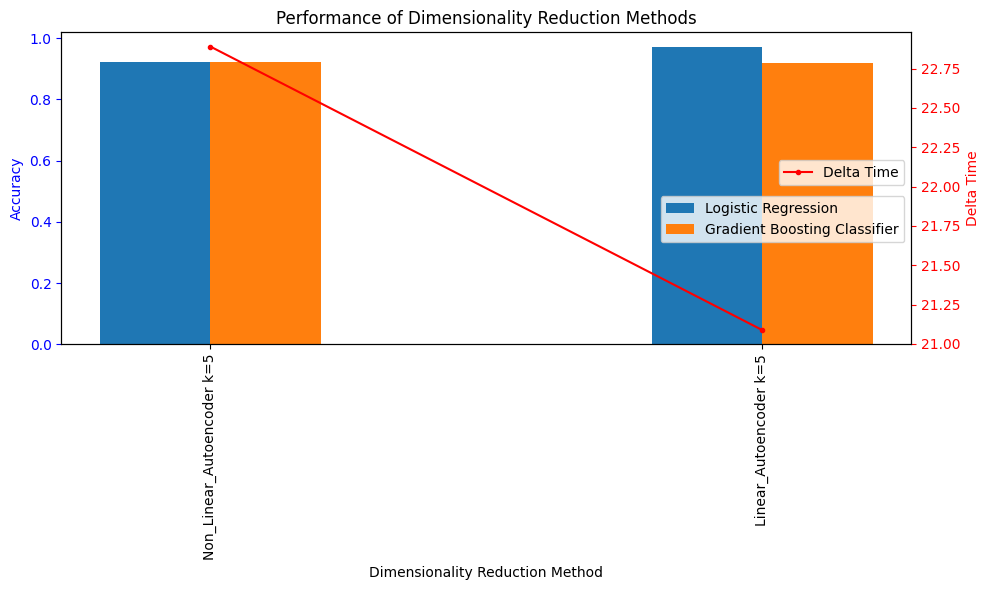

In [44]:
method_score_tuple = evaluate_and_plot(encoder_results, y_train, y_test)

In [45]:
print_best_worst(method_score_tuple)

Best performing methods for Logistic Regression: Linear_Autoencoder k=5 with accuracy: 0.9707602339181286
Worst performing methods for Logistic Regression: Non_Linear_Autoencoder k=5 with accuracy: 0.9239766081871345
Best performing methods for Gradient Boosting Classifier: Non_Linear_Autoencoder k=5 with accuracy: 0.9239766081871345
Worst performing methods for Gradient Boosting Classifier: Linear_Autoencoder k=5 with accuracy: 0.9181286549707602


<font size="5">**Conclusions:**</font> As we can see, DRA with the autoencoder provides good results for both LR and GBC, although the non-linear encoder providing better results only for GBC. However, we can see that these results are still a little bit worse then with algorithms from sklearn, and of course the training time is bigger.

## Generated data

In [46]:
X_gen, y_gen = make_classification(
    n_samples=500,
    n_features=20,
    n_informative=5,
    n_redundant=3,
    n_repeated=0,
    n_classes=8,
    n_clusters_per_class=1,
    class_sep=0.8,
    random_state=RANDOM_STATE
)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_gen, y_gen,
                                                    test_size=0.3,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y_gen)
sscaler = StandardScaler()
sscaler.fit(X_train)
X_train_norm = sscaler.transform(X_train)
X_test_norm = sscaler.transform(X_test)

mmscaler = MinMaxScaler(clip=True)
mmscaler.fit(X_train)
X_train_mms = mmscaler.transform(X_train)
X_test_mms = mmscaler.transform(X_test)

### Sklearn algorithms dimensionality reduction

  0%|          | 0/18 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_dict_learning.py:2290: FutureWarning: The default value of batch_size will change from 3 to 256 in 1.3.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


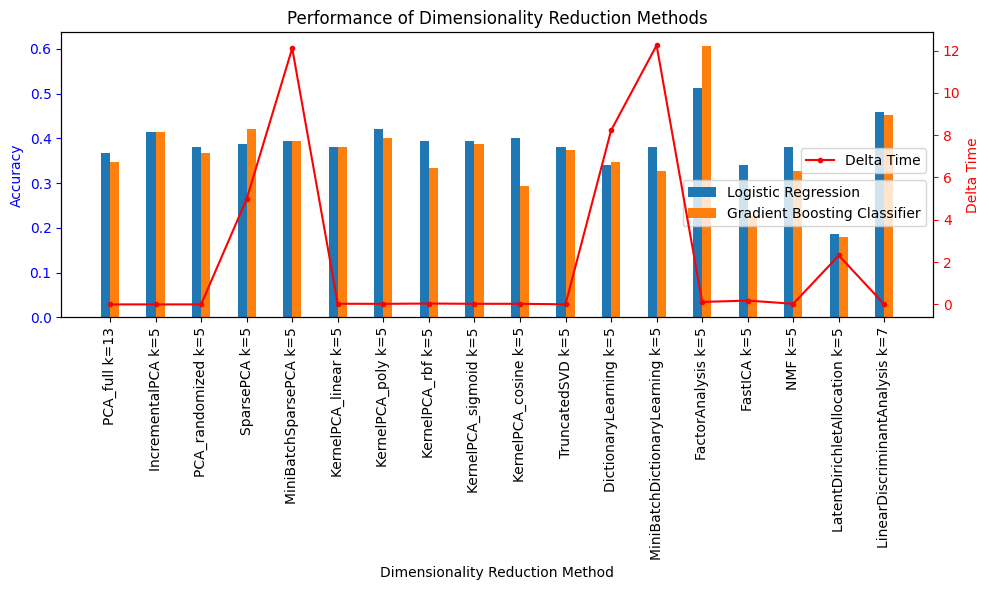

In [51]:
results = perform_dimensionality_reduction(5, X_train_norm, X_train_mms, X_test_norm, X_test_mms, y_train)
method_score_tuple = evaluate_and_plot(results, y_train, y_test)

In [52]:
print_best_worst(method_score_tuple)

Best performing methods for Logistic Regression: FactorAnalysis k=5 with accuracy: 0.5133333333333333
Worst performing methods for Logistic Regression: LatentDirichletAllocation k=5 with accuracy: 0.18666666666666668
Best performing methods for Gradient Boosting Classifier: FactorAnalysis k=5 with accuracy: 0.6066666666666667
Worst performing methods for Gradient Boosting Classifier: LatentDirichletAllocation k=5 with accuracy: 0.18


### Encoder dimensionality reduction

In [57]:
encoder_results = []
criterion = nn.MSELoss()

In [58]:
encode_with_autoencoder(
    X_train_norm, X_test_norm,
    encoder_results, criterion, n_components=5, linear=True, epochs=25000)

  0%|          | 0/25000 [00:00<?, ?it/s]

epoch 2500 	 Loss: 0.6329
epoch 5000 	 Loss: 0.6281
epoch 7500 	 Loss: 0.6388
epoch 10000 	 Loss: 0.6334
epoch 12500 	 Loss: 0.6264
epoch 15000 	 Loss: 0.6249
epoch 17500 	 Loss: 0.634
epoch 20000 	 Loss: 0.6297
epoch 22500 	 Loss: 0.638
epoch 25000 	 Loss: 0.63
Epoch:17150 checkpoint with loss:0.6102088588469019 loaded.


In [59]:
encode_with_autoencoder(
    X_train_norm, X_test_norm,
    encoder_results, criterion, n_components=5, linear=False, epochs=25000)

  0%|          | 0/25000 [00:00<?, ?it/s]

epoch 2500 	 Loss: 0.7041
epoch 5000 	 Loss: 0.6928
epoch 7500 	 Loss: 0.7034
epoch 10000 	 Loss: 0.6814
epoch 12500 	 Loss: 0.7096
epoch 15000 	 Loss: 0.7145
epoch 17500 	 Loss: 0.7028
epoch 20000 	 Loss: 0.7081
epoch 22500 	 Loss: 0.7004
epoch 25000 	 Loss: 0.7147
Epoch:17062 checkpoint with loss:0.6661722484643299 loaded.


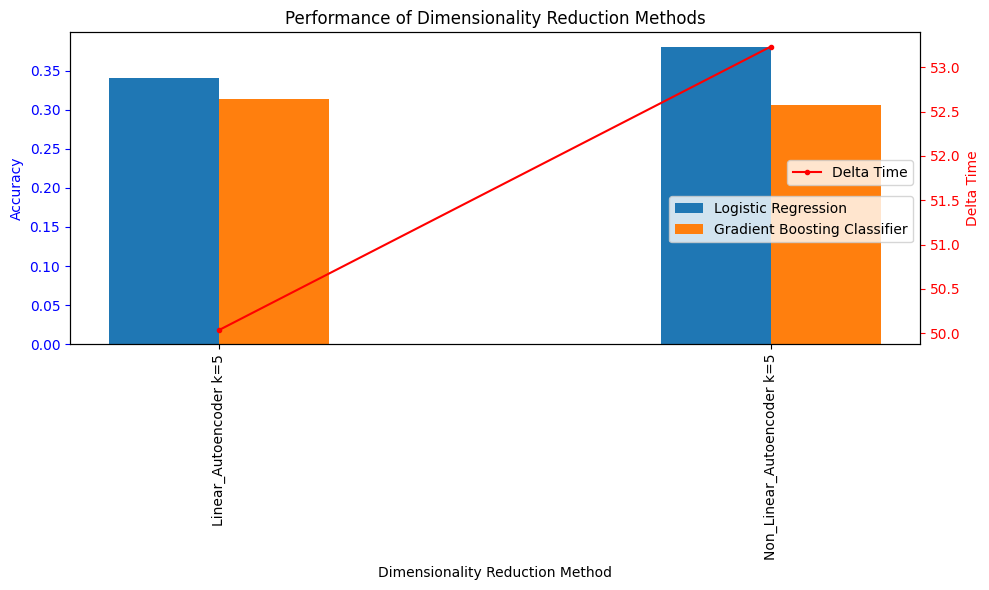

In [60]:
method_score_tuple = evaluate_and_plot(encoder_results, y_train, y_test)

In [61]:
print_best_worst(method_score_tuple)

Best performing methods for Logistic Regression: Non_Linear_Autoencoder k=5 with accuracy: 0.38
Worst performing methods for Logistic Regression: Linear_Autoencoder k=5 with accuracy: 0.34
Best performing methods for Gradient Boosting Classifier: Linear_Autoencoder k=5 with accuracy: 0.31333333333333335
Worst performing methods for Gradient Boosting Classifier: Non_Linear_Autoencoder k=5 with accuracy: 0.30666666666666664


<font size="5">**Conclusions:**</font> As we can see, for the generated data, the outcomes from using different DRA are now much diverse for both LR and GBC, as well as the fitting time. The sklearn methods still provide better results then autoencoders, although here the difference is much bigger. However, we can see that in the case of generated data using Gradient Boosting Classifier with FactorAnalysis provided us the best accuracy with a large gap with other algorithms.